Import Input Files and Models

In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp -r "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/3_Pipeline/2_code_3_classification_model_Yolov10-S/input" -d '/content/'

In [ ]:
cp -r "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/3_Pipeline/2_code_3_classification_model_Yolov10-S/model" -d '/content/'

In [ ]:
!git clone https://github.com/THU-MIG/yolov10.git

Cloning into 'yolov10'...
remote: Enumerating objects: 20329, done.
remote: Counting objects: 100% (1527/1527), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 20329 (delta 1450), reused 1363 (delta 1351), pack-reused 18802
Receiving objects: 100% (20329/20329), 11.19 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (14326/14326), done.


In [ ]:
cd yolov10

/content/yolov10


In [ ]:
!pip install .

Processing /content/yolov10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.meta

In [ ]:
cd ..

/content


In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.2 MB/s eta 0:00:00


In [ ]:
# Modules for Detection and Displaying results
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLOv10

# Modules for Classification
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import keras_cv
from keras.optimizers import AdamW

In [ ]:
# Load Image Detection Model
object_detection_model = YOLOv10('/content/model/object_detection/object_detection_best.pt')

In [ ]:
# Load Image Classification Model
classification_model = load_model('/content/model/image_classification/ensemble_model_best_30_epoch.keras')

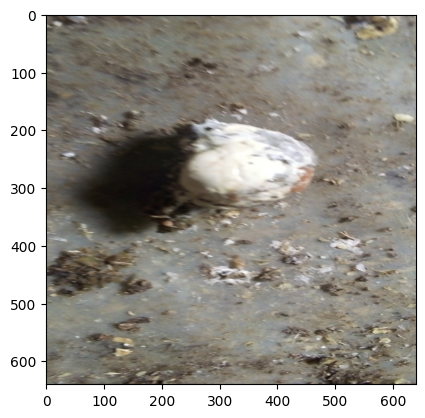

In [ ]:
# Take test image - OG
HOME = os.getcwd()
file_name = 'salmo.113'
image_path = f'/content/input/{file_name}.jpg'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()
# Create a Matplotlib figure and axis
fig, ax = plt.subplots(1)
# plot image, then draw bouding boxes at the end on it
ax.imshow(image_rgb)


0: 640x640 1 salmo, 397.9ms
Speed: 8.2ms preprocess, 397.9ms inference, 26.4ms postprocess per image at shape (1, 3, 640, 640)
tensor([[210.0527, 177.3755, 487.5443, 345.5219]])
1/1 [==============================] - 7s 7s/step


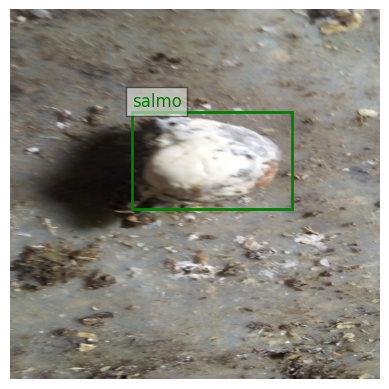

In [ ]:
# Predict bounding box
results = object_detection_model.predict(image_bgr)
bounding_boxes = results[0].boxes.xyxy
print(bounding_boxes)

# Get image dimensions
image_height, image_width, _ = image_rgb.shape

fig, ax = plt.subplots(1)
# plot image, then draw bouding boxes at the end on it
ax.imshow(image_rgb)

for box in bounding_boxes:
  # Get bounding box coordinates
  x1, y1, x2, y2 = map(int, box)

  # Ensure coordinates are within image bounds
  x1 = max(0, min(x1, image_width - 1))
  y1 = max(0, min(y1, image_height - 1))
  x2 = max(0, min(x2, image_width - 1))
  y2 = max(0, min(y2, image_height - 1))

  # Crop the RoI
  roi = image_rgb[y1:y2, x1:x2]
  # plt.imshow(roi)
  # plt.axis('off')  # Turn off axis numbers and ticks
  # plt.show()
  if roi.size == 0:
    continue

  #========= Image Classification
  # Define the custom objects
  # custom_objects = {
  #       'EfficientNetV2Backbone': keras_cv.models.EfficientNetV2Backbone,
  #       'ImageClassifier': keras_cv.models.ImageClassifier,
  #       'AdamW': AdamW
  # }

  class_names_list = ['cocci','healthy','ncd','salmo']

  # Load the saved model with custom objects
  # Resize the ROI to the model input size (224x224)
  roi_resized = cv2.resize(roi, (224, 224))

  # Normalize the ROI (if your model expects normalized input)
  roi_resized = roi_resized / 255.0

  # Expand the dimensions to match the expected input shape (1, 260, 260, 3)
  roi_resized = np.expand_dims(roi_resized, axis=0)
  # Make a prediction
  predictions = classification_model.predict(roi_resized)

  # Interpret the prediction (this depends on your model's output format)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_names_list[predicted_class_index]

  # Draw bounding box
  rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
  ax.add_patch(rect)

  # Draw label
  plt.text(x1, y1 - 10, predicted_class_name, fontsize=12, color='g', bbox=dict(facecolor='white', alpha=0.5))

# ========Display the final result
plt.axis('off')
plt.show()

In [ ]:
#TODO: Predicting on Collage

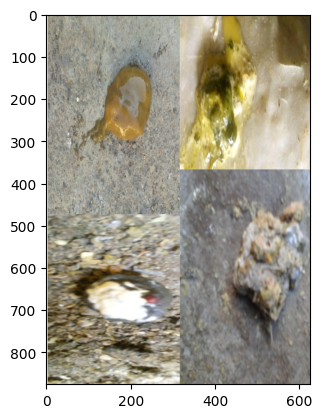

In [ ]:
# Take test image - OG
HOME = os.getcwd()
file_name = 'fecal_collage_1'
image_path = f'/content/input/{file_name}.png'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)
# plt.axis('off')  # Turn off axis numbers and ticks
# plt.show()
# Create a Matplotlib figure and axis
fig, ax = plt.subplots(1)
# plot image, then draw bouding boxes at the end on it
ax.imshow(image_rgb)


0: 640x480 1 cocci, 1 healthy, 1 ncd, 1 salmo, 217.9ms
Speed: 3.2ms preprocess, 217.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
tensor([[437.4307, 431.7010, 620.6736, 729.1075],
        [ 96.6628, 118.6077, 249.9298, 308.4892],
        [346.4437,   2.2233, 493.6336, 316.7831],
        [ 81.5597, 620.0801, 267.5790, 731.0154]])
1/1 [==============================] - 0s 208ms/step


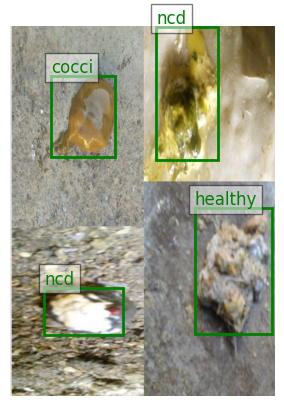

In [ ]:
# Predict bounding box
results = object_detection_model.predict(image_bgr)
bounding_boxes = results[0].boxes.xyxy
print(bounding_boxes)

# Get image dimensions
image_height, image_width, _ = image_rgb.shape

fig, ax = plt.subplots(1)
# plot image, then draw bouding boxes at the end on it
ax.imshow(image_rgb)

for box in bounding_boxes:
  # Get bounding box coordinates
  x1, y1, x2, y2 = map(int, box)

  # Ensure coordinates are within image bounds
  x1 = max(0, min(x1, image_width - 1))
  y1 = max(0, min(y1, image_height - 1))
  x2 = max(0, min(x2, image_width - 1))
  y2 = max(0, min(y2, image_height - 1))

  # Crop the RoI
  roi = image_rgb[y1:y2, x1:x2]
  # plt.imshow(roi)
  # plt.axis('off')  # Turn off axis numbers and ticks
  # plt.show()
  if roi.size == 0:
    continue

  #========= Image Classification
  # # Define the custom objects
  # custom_objects = {
  #       'EfficientNetV2Backbone': keras_cv.models.EfficientNetV2Backbone,
  #       'ImageClassifier': keras_cv.models.ImageClassifier,
  #       'AdamW': AdamW
  # }

  class_names_list = ['cocci','healthy','ncd','salmo']

  # Load the saved model with custom objects
  # Resize the ROI to the model input size (224x224)
  roi_resized = cv2.resize(roi, (224, 224))

  # Normalize the ROI (if your model expects normalized input)
  roi_resized = roi_resized / 255.0

  # Expand the dimensions to match the expected input shape (1, 260, 260, 3)
  roi_resized = np.expand_dims(roi_resized, axis=0)
  # Make a prediction
  predictions = classification_model.predict(roi_resized)

  # Interpret the prediction (this depends on your model's output format)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_names_list[predicted_class_index]

  # Draw bounding box
  rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
  ax.add_patch(rect)

  # Draw label
  plt.text(x1, y1 - 10, predicted_class_name, fontsize=12, color='g', bbox=dict(facecolor='white', alpha=0.5))

# ========Display the final result
plt.axis('off')
plt.show()